## Imports

In [30]:
################ TORCH ################
import torch
# dataset imports
import torchvision
from torch.utils.data import DataLoader
# Neural Network import
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#######################################

############ OTHERS ############
# visulization
import matplotlib.pyplot as plt
################################

## Set up

In [31]:
n_epochs = 8
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

## Load dataset

In [32]:
TRANS = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))])

############## Train Dataset ##############
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
    root       = './data/', 
    train      = True, 
    download   = True,
    transform  = TRANS),
    batch_size   = batch_size_train, 
    shuffle      = True)
############################################

############## Test Dataset ##############
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
    root       = './data/', 
    train      = False, 
    download   = True,
    transform  = TRANS),
    batch_size = batch_size_test,
   shuffle     = True)
###########################################

## Structure Neural Network

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net()
network

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## Optimizer

In [34]:
optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

## Loss Function

In [35]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

## Training function

In [36]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')
          
train(1)

/tmp/ipykernel_16533/1728475621.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.371851
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.366941
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.253085
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.258119
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.279200
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.284118
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.224427
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.182901
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.092957
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.014003
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.066881
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.937319
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.780319
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.727874
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.722512
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.627026
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.649031
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.317975
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.215969
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.311500
Train Epoch: 1 [12800/60000 (

## Test function

In [37]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
test()

/tmp/ipykernel_16533/1728475621.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/undergraduate/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2104, Accuracy: 9396/10000 (94%)



## Training procedure

In [38]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_16533/1728475621.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.2104, Accuracy: 9396/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.432211
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.493164
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.328533
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.330705
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.353107
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.875534
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.367126
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.529607
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.465136
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.487136
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.501760
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.523213
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.245734
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.409387
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.444277
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.530041
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.707153
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.309332
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.344954
Train Epoch: 1 [12160

## Plot figure about accuracy

/tmp/ipykernel_16533/1728475621.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.0533, Accuracy: 9831/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.117410
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.204589
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.243048
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.201105
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.094027
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.099048
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.063625
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.159720
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.068056
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.115458
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.153043
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.115823
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.209172
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.188436
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.181000
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.227865
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.167452
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.200682
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.133045
Train Epoch: 1 [12160

ValueError: x and y must be the same size

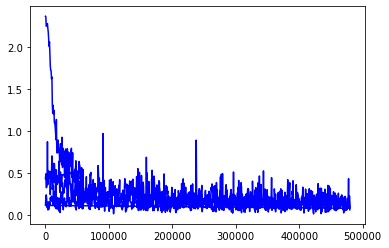

In [39]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

## Plot test result

/tmp/ipykernel_16533/1728475621.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


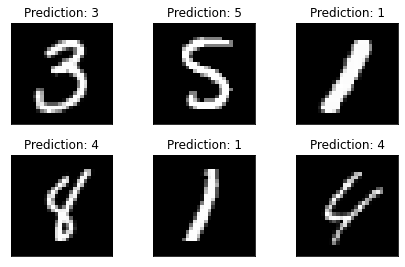

In [40]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()